<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Relé 3</h3></center>

### 1. Imports

In [164]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Acceder al sistema operativo
import os
import glob
import shutil
import random

### 2. Model Parameters

In [165]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### 3. Model Creation

##### 3.1. FaultDetector Class Creation

In [166]:
# Model Creation


class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


##### 3.2. Model Instance Initialization

In [167]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate decay (optional)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Number of parameters: 1861


### 4. Dataset Creation

##### 4.1. Dataset Class Creation

In [168]:
from utils.signalload import CSV_pandas_path
from utils.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir,
        signal_name,
        max_window_idx=193,
        window_length=64,
        step=1,
        test=False,
    ):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test
        self.signal_name = signal_name

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = step

    def __getitem__(self, index):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signal, t, _ = CSV_pandas_path(csv_full_path).load_data(self.signal_name)
        signal_windows, t_windows = list(
            map(moving_window, [signal, t], repeat(window_length), repeat(step))
        )

        # select window

        signal_window = signal_windows[window_idx]
        signal_window = np.expand_dims(signal_window, axis=1)
        t_window = t_windows[window_idx]

        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        # For dataset visualization return following information
        signal_window = torch.from_numpy(np.copy(signal_window)).float()
        label = torch.from_numpy(label).float()
        if self.test == True:
            return signal_window, t_window, label, csv_name, index, window_idx

        # For training only signals and labels are required
        
        return signal_window, label

    def __len__(self):
        return self.csv_amount * self.max_window_idx

##### 4.2. Database Directory Creation 

In [184]:
# Creating Dataset Folders

dataset_dir_full = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/fault_02/"
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R3/"

max_window_idx = 130
n_events = 54


def dataset_creator(source_path, target_path, signal_list=False):
    csv_list = glob.glob(f"{source_path}*.csv")
    if not os.path.isdir(target_path):
        print("creating")
        os.makedirs(target_path)
    else:
        file_list = glob.glob(f"{target_path}*.csv")
        for file in file_list:
            os.remove(file)
    csv_list = random.sample(csv_list, n_events)
    print(f"copying {len(csv_list)} files...")
    for csv in csv_list:
        source_path = csv
        target_path = target_path
        shutil.copy(source_path, target_path)
    print("finished")
    
    if signal_list == True:
        print("Available Relays (current):")
        CSV_pandas_path(csv_list[0]).relay_list()


# Crear los 3 Datasets para entrenar los relés individualmente
dataset_creator(dataset_dir_full, dataset_dir, signal_list=True)


copying 54 files...
finished
Available Relays (current):
I: X0038A-X0043A
I: X0038B-X0043B
I: X0038C-X0043C
I: X0048A-X0053A
I: X0048B-X0053B
I: X0048C-X0053C
I: X0060A-X0065A
I: X0060B-X0065B
I: X0060C-X0065C
I: X0066A-X0067A
I: X0066B-X0067B
I: X0066C-X0067C
I: X0023A-R1A
I: X0023B-R1B
I: X0023C-R1C
I: X0004A-R2A
I: X0004B-R2B
I: X0004C-R2C
I: X0071A-R3A
I: X0071B-R3B
I: X0071C-R3C


##### 4.3. Dataset and Dataloader Instances Creation

In [188]:
# Load Dataset
# signal_name = "I: X0071A-R3A"
# signal_name = "I: X0071B-R3B"
signal_name = "I: X0071C-R3C"
dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name
)
train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.


### 5. Model Training


##### 5.1. Train / Test(dev) Loop Creation

In [175]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer, return_loss = False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list



def test(dataloader, model, loss_fn, return_metrics=False):
    print(len(dataloader))
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    if return_metrics==True:
        return correct*100, test_loss


##### 5.2. Training the model

In [189]:
epochs = 1
for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}\n--------------------------------")
    # train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
    accuracy, _ = test(test_dataloader, model, loss_fn, return_metrics=True)

Epoch 1
--------------------------------
22
Test Error: 
 Accuracy: 2.3%, Avg loss: 0.047461 



##### 5.3. Loss visualization

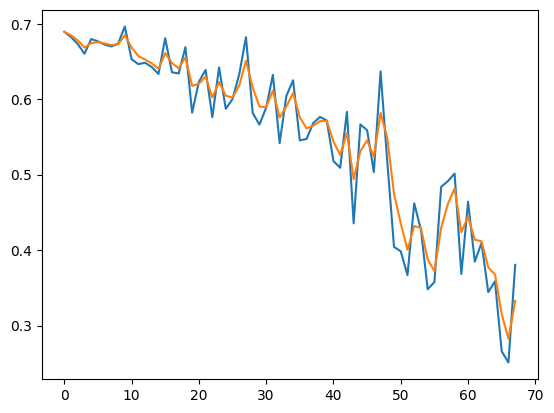

In [51]:
# Best MOdel So Far
mini_batch_list = [index for index, _ in enumerate(train_loss)]
train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)

##### 5.4. Saving the Model

In [182]:
# # Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights_R3_934.pth')
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))

<All keys matched successfully>

### 6. Results Visualization


#### 6.1. Confussion Matrix Results Table Function

In [140]:
# Data visualization (CPU)


def confussion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "True"
    else:
        label += "False"
    if pred_label == 1:
        label += " positive"
    else:
        label += " negative"
    return label


def confussion_matrix(x, labels):
    data = {
        "Pred probability": torch.reshape(x, (-1,)).numpy(),
        "Pred label": torch.reshape(torch.round(x), (-1,)).int().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().numpy(),
    }
    df = pd.DataFrame(data)
    df["prueba"] = confussion_matrix_pandas(df["Pred label"], df["True label"])
    return df


confussion_matrix_pandas = np.vectorize(confussion_matrix_labels)


##### 6.2. Plotly Plot

In [142]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 3840
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)

x = model(signal_windows[0:9].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confussion_matrix(x, labels[0:9])
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    fig.add_trace(
        go.Scatter(
            name=i, x=t_windows[i, :], y=signal_windows[i, :, 0], marker_color="black"
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()


   Pred probability  Pred label  True label          prueba
0          0.987779           1           1   True positive
1          0.989260           1           1   True positive
2          0.982080           1           1   True positive
3          0.334109           0           0   True negative
4          0.977939           1           1   True positive
5          0.989679           1           1   True positive
6          0.725025           1           0  False positive
7          0.773843           1           0  False positive
8          0.645992           1           0  False positive


##### 6.3. Matlab Plots

   Pred probability  Pred label  True label          prueba
0          0.009934           0           1  False negative
1          0.011236           0           0   True negative
2          0.009163           0           0   True negative
3          0.009425           0           1  False negative
4          0.006801           0           1  False negative
5          0.008318           0           0   True negative
6          0.978771           1           1   True positive
7          0.006461           0           0   True negative
8          0.009479           0           1  False negative


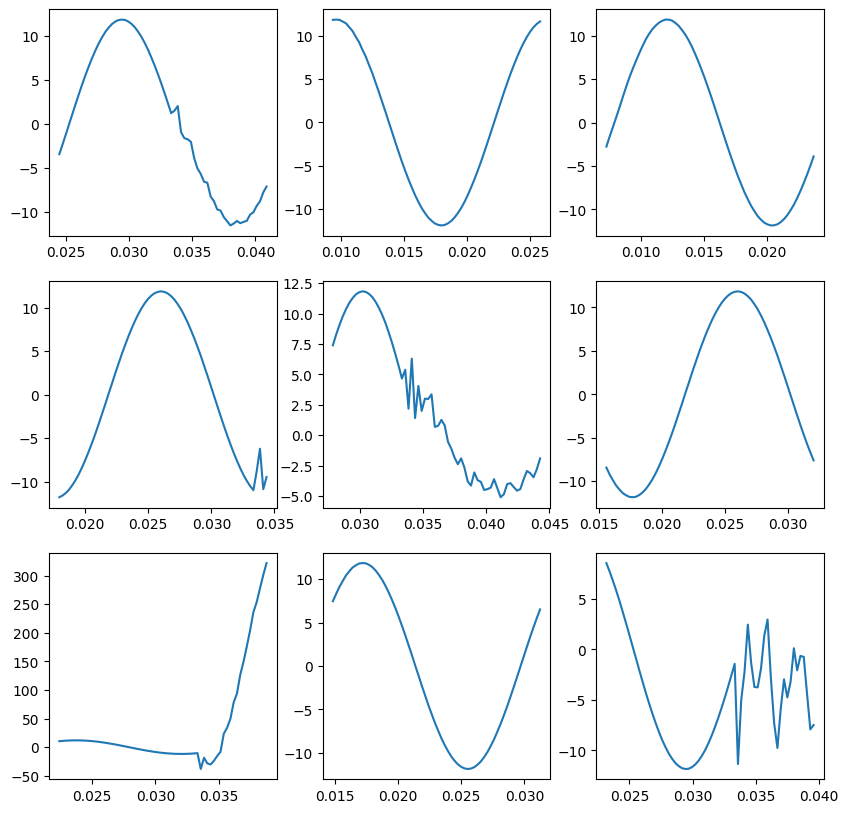

In [32]:
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)
fs = 3840

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confussion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t_windows[i, :], signal_windows[i, :, 0])


### 7. References
1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->